In [2]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

In [3]:
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CovidDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.filenames = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]

        img_path = os.path.join(self.img_dir, fname)
        img = cv2.imread(img_path, 0)
        
        assert img is not None
        assert img.shape == (IMG_SIZE, IMG_SIZE)

        img = img / 255.0 # normalize to [0,1]
        img = (img - 0.5) / 0.5 # standardize to mean=0, std=1
        img = np.stack([img] * 3, axis=0) #shape (3, H, W)
        img = torch.tensor(img, dtype=torch.float32)

        if self.mask_dir is not None:
            mask_path = os.path.join(self.mask_dir, fname)
            mask = cv2.imread(mask_path, 0)
            mask = (mask > 0).astype(np.float32) #binarize
            mask = mask[None, :, :] #shape (1, H, W)
            
        else:
            mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32) #dummy mask
            
        mask = torch.tensor(mask, dtype=torch.float32) #shape (1, H, W)
        
        return img, mask, fname

In [6]:
train_dataset = CovidDataset(
    img_dir=r"D:\USTH\MLmed\anasmohammedtahir\covidqu\versions\7\Infection_Segmentation_Data\Infection_Segmentation_Data\Train\COVID-19\images",
    mask_dir=r"D:\USTH\MLmed\anasmohammedtahir\covidqu\versions\7\Infection_Segmentation_Data\Infection_Segmentation_Data\Train\COVID-19\infection_masks"
)

val_dataset = CovidDataset(
    img_dir=r"D:\USTH\MLmed\anasmohammedtahir\covidqu\versions\7\Infection_Segmentation_Data\Infection_Segmentation_Data\Val\COVID-19\images",
    mask_dir=r"D:\USTH\MLmed\anasmohammedtahir\covidqu\versions\7\Infection_Segmentation_Data\Infection_Segmentation_Data\Val\COVID-19\infection_masks"
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
)
print(len(train_loader), len(val_loader))

303 74


In [7]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)


dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss  = smp.losses.SoftBCEWithLogitsLoss()

def loss_fn(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:

from tqdm.notebook import tqdm

best_val_loss = float("inf")
train_losses = []
val_losses = []

for epoch in range(EPOCHS):

    # ---- TRAIN ----
    model.train()
    train_loss = 0.0
    
    train_bar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{EPOCHS} [TRAIN]",
        leave=False
    )
    
    for imgs, masks, _ in train_bar:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        preds = model(imgs)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # VALIDATION 
    model.eval()
    val_loss = 0.0

    val_bar = tqdm(
        val_loader,
        desc=f"Epoch {epoch+1}/{EPOCHS} [VAL]",
        leave=False
    )
    
    with torch.no_grad():
        for imgs, masks, _ in val_bar:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())
            
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )

    # SAVE BEST MODEL
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "unet_covid_best_2.pth")
        print("✔ Best model saved")

print("Training finished.")

Epoch 1/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 1/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [1/20] | Train Loss: 0.4572 | Val Loss: 0.2943
✔ Best model saved


Epoch 2/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 2/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [2/20] | Train Loss: 0.3644 | Val Loss: 0.2783
✔ Best model saved


Epoch 3/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 3/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [3/20] | Train Loss: 0.3010 | Val Loss: 0.2508
✔ Best model saved


Epoch 4/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 4/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [4/20] | Train Loss: 0.2439 | Val Loss: 0.2780


Epoch 5/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 5/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [5/20] | Train Loss: 0.2276 | Val Loss: 0.3255


Epoch 6/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 6/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [6/20] | Train Loss: 0.2027 | Val Loss: 0.2409
✔ Best model saved


Epoch 7/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 7/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [7/20] | Train Loss: 0.1803 | Val Loss: 0.2467


Epoch 8/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 8/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [8/20] | Train Loss: 0.1739 | Val Loss: 0.2708


Epoch 9/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 9/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [9/20] | Train Loss: 0.1584 | Val Loss: 0.2520


Epoch 10/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 10/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [10/20] | Train Loss: 0.1425 | Val Loss: 0.2338
✔ Best model saved


Epoch 11/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 11/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [11/20] | Train Loss: 0.1318 | Val Loss: 0.2498


Epoch 12/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 12/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [12/20] | Train Loss: 0.1385 | Val Loss: 0.2367


Epoch 13/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 13/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [13/20] | Train Loss: 0.1196 | Val Loss: 0.2538


Epoch 14/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 14/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [14/20] | Train Loss: 0.1158 | Val Loss: 0.2347


Epoch 15/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 15/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [15/20] | Train Loss: 0.1051 | Val Loss: 0.2571


Epoch 16/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 16/20 [VAL]:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch [16/20] | Train Loss: 0.1066 | Val Loss: 0.2490


Epoch 17/20 [TRAIN]:   0%|          | 0/303 [00:00<?, ?it/s]

KeyboardInterrupt: 

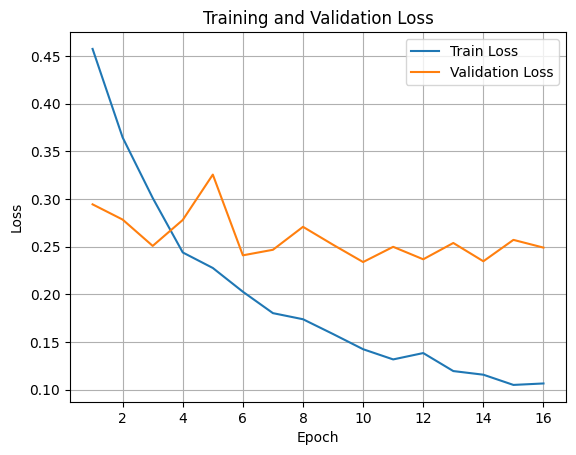

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
